<div style="background-color: lightblue; color: black; padding: 20px; font-weight: bold; font-size: 15px;">Extra Trees</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

RSEED=42

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Read data - Here: Data with 3x rolling shifted average & without store & department dummies</div>

In [2]:
df = pd.read_pickle('../data/data_combined_clean_features_11.pkl')

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Train test split</div>

In [3]:
#define train, validation and test dataset
train = df[df['Date'] < "2012-01-06"].reset_index(drop=True)
validation = df[(df['Date'] >= "2012-01-06") & (df['Date'] <= "2012-06-08")].reset_index(drop=True)
test = df[df['Date'] > "2012-06-08"].reset_index(drop=True)
 

#define features and target
X_train = train.drop(columns=['Weekly_Sales', 'Date'])
y_train = train['Weekly_Sales']

X_validation = validation.drop(columns=['Weekly_Sales', 'Date'])
y_validation = validation['Weekly_Sales']

X_test = test.drop(columns=['Weekly_Sales', 'Date'])
y_test = test['Weekly_Sales']  

In [4]:
# writing a function to get evaluation metrics for all data sets
def get_metrics(y, y_hat, data_kind):
    '''insert target, predicted target 
    and which kind of dataset as a string'''
    
    mean = y.mean()
    std = y.std()
    mse = mean_squared_error(y, y_hat)
    rmse = np.sqrt(mse)

    print(5*'- - ')
    print(f'Metrics for {data_kind}')
    print('Mean weekly sales:', mean.round(3))
    print('Standard deviation weekly sales:', std.round(3))
    print('MSE:', mse.round(3))
    print('RMSE:', rmse.round(3))
    print(5*'- - ')


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Best model: ExtraTrees</div>

In [5]:
# instantiate model
model = ExtraTreesRegressor(
    max_depth=25, 
    max_features=0.5, 
    min_samples_leaf=1, 
    n_estimators= 100,
    random_state=42)

# fit the model with train data 
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_validation = model.predict(X_validation)
y_pred_test = model.predict(X_test)

In [6]:
get_metrics(y_train, y_pred_train, 'Train')
get_metrics(y_validation, y_pred_validation, 'Validation')
get_metrics(y_test, y_pred_test, 'Test')

- - - - - - - - - - 
Metrics for Train
Mean weekly sales: 17639.364
Standard deviation weekly sales: 23534.607
MSE: 1190150.665
RMSE: 1090.94
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Validation
Mean weekly sales: 17342.499
Standard deviation weekly sales: 22893.483
MSE: 11017994.196
RMSE: 3319.336
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Test
Mean weekly sales: 17402.01
Standard deviation weekly sales: 22530.901
MSE: 7087163.445
RMSE: 2662.173
- - - - - - - - - - 


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Adding predicted values to train, validation and test dataframe</div>

In [7]:
train['Predicted_Sales'] = y_pred_train
validation['Predicted_Sales'] = y_pred_validation
test['Predicted_Sales'] = y_pred_test

In [8]:
# concat dataframes
validation_and_test = pd.concat([validation, test], axis=0)

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Getting results for prediction period </div>

In [9]:
print ('Weeks of prediction period:', validation_and_test.Date.nunique())

Weeks of prediction period: 43


In [11]:
get_metrics(validation_and_test.Weekly_Sales, 
            validation_and_test.Predicted_Sales, 'Validation and Test')



- - - - - - - - - - 
Metrics for Validation and Test
Mean weekly sales: 17370.179
Standard deviation weekly sales: 22725.48
MSE: 9189700.823
RMSE: 3031.452
- - - - - - - - - - 


In [12]:
print('Total Sales during prediction period:', validation_and_test.Weekly_Sales.sum())

Total Sales during prediction period: 1986801036.38


In [13]:
print('Standard deviation prediction period:', validation_and_test.Weekly_Sales.std().round(2))

Standard deviation prediction period: 22725.48


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Metrics for each store during prediction period </div>

In [ ]:
for store in validation_and_test.Store.unique():
    print(f'Values for store {store}')
    store_data = validation_and_test[validation_and_test['Store'] == store]
    
    get_metrics(store_data['Weekly_Sales'], store_data['Predicted_Sales'], 'Validation and Test')


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Plotting actual target versus predicted target - Prediction period </div>

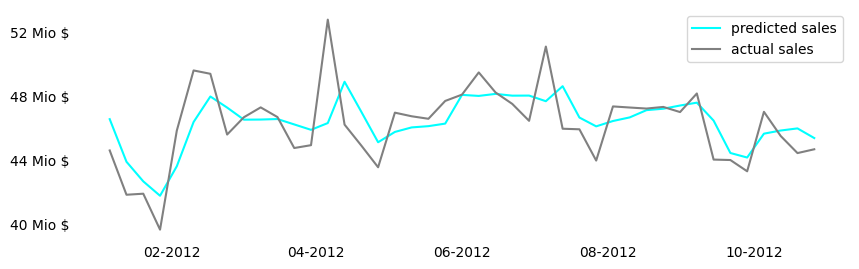

In [15]:
plt.figure(figsize=(10, 3))

#plotting lines for predicted and actual sales
sns.lineplot(data=validation_and_test, x='Date', 
             y=validation_and_test.groupby(['Date'])['Predicted_Sales'].transform('sum'), 
             label='predicted sales', errorbar=None,
             color='cyan')
sns.lineplot(data=validation_and_test, x='Date', 
             y=validation_and_test.groupby(['Date'])['Weekly_Sales'].transform('sum'), 
             label ='actual sales', color='grey', 
             errorbar=None) #linestyle='--', 

# y ticks formatting
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x / 1e6:.0f} Mio $')
ytick_positions = [plt.gca().get_yticks()[1], plt.gca().get_yticks()[3], 
                   plt.gca().get_yticks()[5], plt.gca().get_yticks()[7]]

plt.gca().set_yticks(ytick_positions)
plt.gca().tick_params(axis='y', which='both', length=0)

# x ticks formatting
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)

xtick_positions = [plt.gca().get_xticks()[1], plt.gca().get_xticks()[3], 
                   plt.gca().get_xticks()[5], plt.gca().get_xticks()[7],
                   plt.gca().get_xticks()[9]]

plt.gca().set_xticks(xtick_positions)
plt.gca().tick_params(axis='x', which='both', length=0)

sns.despine(top=True, right=True, left=True, bottom=True)

plt.title('')#Prediction period - Weekly sales actual vs predicted 
plt.ylabel('')#weekly sales
plt.xlabel('')#Date
plt.legend();

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Printing different seasonality - stores with extreme patterns</div>

In [16]:
# seperate dataframe for total sale per week on storelevel
df_store_weekly_sales = df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

# dataframes for plotting single store pattern
df_store_10 = df_store_weekly_sales.query('Store==10')
df_store_33 = df_store_weekly_sales.query('Store==33')

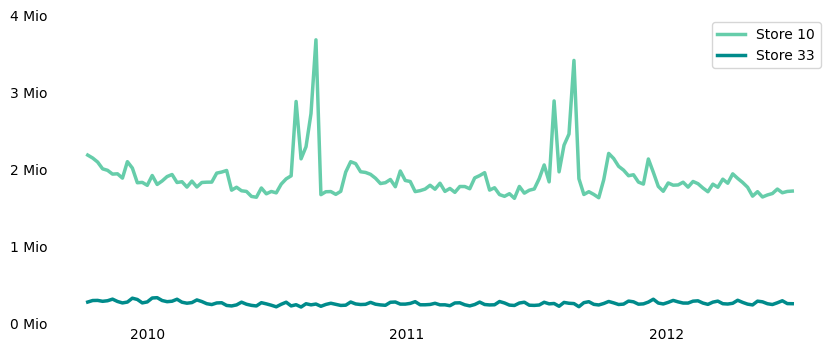

In [17]:
# plot extreme seasonal patterns
plt.figure(figsize=(10, 4))

sns.lineplot(x = df_store_10['Date'], y = df_store_10['Weekly_Sales'], 
              linewidth=2.5, color='mediumaquamarine', label='Store 10')

sns.lineplot(x = df_store_33['Date'], y = df_store_33['Weekly_Sales'], 
              linewidth=2.5, color='darkcyan', label='Store 33')

sns.despine(top=True, right=True, left=True, bottom=True)

# y ticks as Mio and not all of them
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x / 1e6:.0f} Mio')

# Festlegen der y-Achsenticks
ytick_positions = [0, 1e6, 2e6, 3e6, 4e6]
plt.yticks(ytick_positions)

plt.gca().tick_params(axis='y', which='both', length=0)

# x ticks as Year and only 1st per year
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%Y")
plt.gca().xaxis.set_major_formatter(date_format)

xtick_positions = [plt.gca().get_xticks()[1], plt.gca().get_xticks()[4], plt.gca().get_xticks()[7]]
plt.gca().set_xticks(xtick_positions)
plt.gca().tick_params(axis='x', which='both', length=0)

plt.ylabel('')
plt.xlabel('')
plt.title('', pad=30); #'Store 10 an 33 weekly sales on store level'


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Tamplate to look at just one store and one department</div><br>

Finally this plot has not been used within the presentation, but it is kept for possible future work.

In [18]:
validation_and_test_one_store_one_dept = validation_and_test.query('Store==8 and Dept==10')

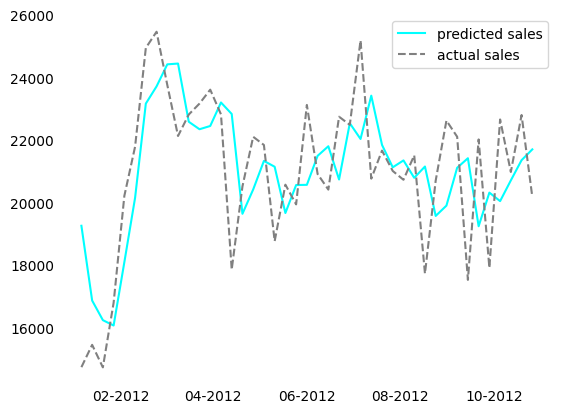

In [22]:
sns.lineplot(data=validation_and_test_one_store_one_dept, 
             x='Date', y=validation_and_test_one_store_one_dept.groupby(['Date'])['Predicted_Sales'].transform('sum'), 
             label='predicted sales', errorbar=None,
             color='cyan')
sns.lineplot(data=validation_and_test_one_store_one_dept, 
             x='Date', y=validation_and_test_one_store_one_dept.groupby(['Date'])['Weekly_Sales'].transform('sum'), 
             label ='actual sales', errorbar=None, 
             color='grey', linestyle='--')

sns.despine(top=True, right=True, left=True, bottom=True)

# y ticks formatting
#plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x / 1e6:.0f} Mio $')
ytick_positions = [plt.gca().get_yticks()[1], plt.gca().get_yticks()[2], 
                   plt.gca().get_yticks()[3], plt.gca().get_yticks()[4],
                   plt.gca().get_yticks()[5], plt.gca().get_yticks()[6]]

plt.gca().set_yticks(ytick_positions)
plt.gca().tick_params(axis='y', which='both', length=0)

# x ticks formatting
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)

xtick_positions = [plt.gca().get_xticks()[1], plt.gca().get_xticks()[3], 
                   plt.gca().get_xticks()[5], plt.gca().get_xticks()[7],
                   plt.gca().get_xticks()[9]]

plt.gca().set_xticks(xtick_positions)
plt.gca().tick_params(axis='x', which='both', length=0)

plt.title('')#Validation data - Weekly sales actual vs predicted - Store X Department X'
plt.ylabel('')#weekly sales
plt.xlabel('')#date
#plt.xticks(rotation=45)
plt.legend();
#plt.ticklabel_format(style='plain', axis='y');

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Adding prediction of baseline model</div><br>
Finally this plot has not been used within the presentation, but it is kept for possible future work.

In [23]:
# Loading baseline prediction
df_baseline = pd.read_pickle('../data/dataset_prediction_baseline.pkl')

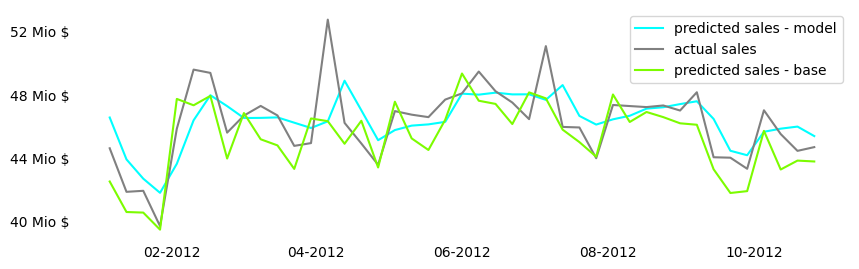

In [24]:
plt.figure(figsize=(10, 3))

#plotting lines for predicted and actual sales
sns.lineplot(data=validation_and_test, x='Date', 
             y=validation_and_test.groupby(['Date'])['Predicted_Sales'].transform('sum'), 
             label='predicted sales - model', errorbar=None,
             color='cyan')
sns.lineplot(data=validation_and_test, x='Date', 
             y=validation_and_test.groupby(['Date'])['Weekly_Sales'].transform('sum'), 
             label ='actual sales', color='grey', 
             errorbar=None) #linestyle='--', 
sns.lineplot(data=df_baseline, x='Date', 
             y=df_baseline.groupby(['Date'])['Weekly_Sales_train_data_mean'].transform('sum'), 
             label = 'predicted sales - base', color='lawngreen',
             errorbar=None)

# y ticks formatting
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x / 1e6:.0f} Mio $')
ytick_positions = [plt.gca().get_yticks()[1], plt.gca().get_yticks()[3], 
                   plt.gca().get_yticks()[5], plt.gca().get_yticks()[7]]

plt.gca().set_yticks(ytick_positions)
plt.gca().tick_params(axis='y', which='both', length=0)

# x ticks formatting
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)

xtick_positions = [plt.gca().get_xticks()[1], plt.gca().get_xticks()[3], 
                   plt.gca().get_xticks()[5], plt.gca().get_xticks()[7],
                   plt.gca().get_xticks()[9]]

plt.gca().set_xticks(xtick_positions)
plt.gca().tick_params(axis='x', which='both', length=0)

sns.despine(top=True, right=True, left=True, bottom=True)
#plt.title('Validation and test data - Weekly sales actual vs predicted')
plt.ylabel('')#weekly sales
plt.xlabel('')#Date
#plt.xticks(rotation=45)
plt.legend();
#plt.ticklabel_format(style='plain', axis='y')

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Getting numbers for prediction period - Store 4 </div><br>
These numbers are needed for the storytelling within the presentation.

In [25]:
baseline_store_4 = df_baseline.query('Store==4')

In [27]:
get_metrics(baseline_store_4['Weekly_Sales_train_data_mean'], baseline_store_4['Weekly_Sales_test_data'], 'Prediction period - Baseline model - Store 4')

- - - - - - - - - - 
Metrics for Prediction period - Baseline model - Store 4
Mean weekly sales: 28936.788
Standard deviation weekly sales: 32214.162
MSE: 36225191.844
RMSE: 6018.737
- - - - - - - - - - 


In [28]:
validation_and_test_store_4 = validation_and_test.query('Store == 4')

In [29]:
print('Sales store 4 in total for prediction period:', 
      validation_and_test_store_4.Weekly_Sales.sum())

Sales store 4 in total for prediction period: 92321217.24


In [30]:
print('Number of observations for prediction period store 4:', 
      validation_and_test_store_4.shape[0])

Number of observations for prediction period store 4: 2924


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Top and Bottom performing stores</div><br>


In [32]:
df = pd.read_pickle('../data/data_combined_clean_2.pkl')

In [34]:
#creating a new dataframe with aggregations for stores
df2 = df.query('Year == 2010 or Year == 2011')
df2 = df2.groupby(['Store', 'Year'])['Weekly_Sales'].sum().reset_index()
df2.rename(columns={'Weekly_Sales': 'Year_Sales'}, inplace=True)
df2['Total_Sales'] = df2.groupby(['Store'])['Year_Sales'].transform('sum')

In [53]:
#getting top and bottom performers on store level
top_performers = df2.groupby('Store')['Year_Sales'].sum().nlargest(3).index
bottom_performers = df2.groupby('Store')['Year_Sales'].sum().nsmallest(3).index

print('Top-performer 2010 and 2011:',top_performers)
print('Bottom-performer 2010 and 2011:',bottom_performers)

Top-performer 2010 and 2011: Index([14, 20, 4], dtype='int64', name='Store')
Bottom-performer 2010 and 2011: Index([33, 44, 5], dtype='int64', name='Store')


In [68]:
# creating a dataframe only with top and bottom stores
df_top_bottom = df2.query('Store==4 or Store==14 or Store==20 or Store ==5 or Store ==33 or Store ==44')
df_top_bottom.head(2)

,Store,Year,Year_Sales,Total_Sales
6,4,2010,9.495042e+07,205216533.8
7,4,2011,1.102661e+08,205216533.8


In [55]:
# here for first create a sorted dataframe
df_top_bottom_sorted = df_top_bottom.sort_values(by='Total_Sales', ascending=False)

# now convert Store into string
df_top_bottom_sorted['Store'] = df_top_bottom_sorted['Store'].astype('str') 

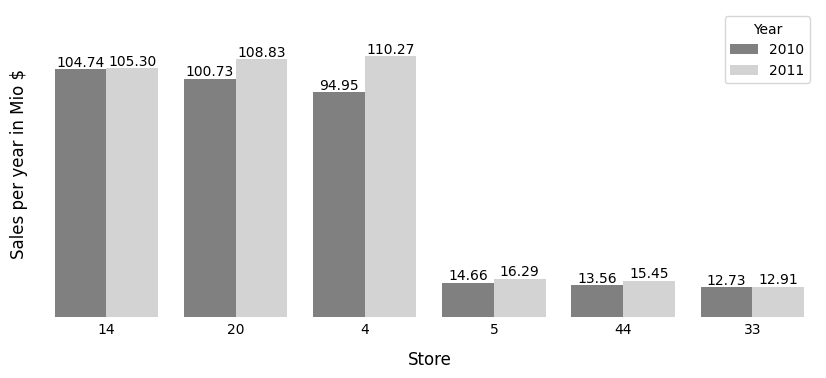

In [100]:
my_pal=['grey', 'lightgrey']

plt.figure(figsize=(10, 4))

ax = sns.barplot(data=df_top_bottom_sorted, x=df_top_bottom_sorted['Store'], y='Year_Sales', hue='Year', palette=my_pal)

# getting clean looking chart
sns.despine(top=True, right=True, left=True, bottom=True)
plt.gca().set_yticks([])
plt.gca().tick_params(axis='x', which='both', length=0)

#def function for format formatting of bar labels
def format_millions(x):
   return f'{x / 1e6:.2f}' # change here decimals

#add labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt=format_millions, label_type='edge')

plt.title('') #Total sales by store 
plt.xlabel('Store', labelpad=10, fontsize=12)
plt.ylabel('Sales per year in Mio $', labelpad=10, fontsize=12)
plt.legend(title='Year')
plt.ylim(0, 130000000);

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Top and Bottom performing departments</div><br>


In [57]:
#creating a new dataframe with aggregations for departments
df3 = df.query('Year == 2010 or Year == 2011')
df3 = df3.groupby(['Dept', 'Year'])['Weekly_Sales'].sum().reset_index()
df3.rename(columns={'Weekly_Sales': 'Year_Sales'}, inplace=True)
df3['Total_Sales'] = df3.groupby(['Dept'])['Year_Sales'].transform('sum')

In [58]:
#getting top and bottom performers on department level
top_performers_dept = df3.groupby('Dept')['Year_Sales'].sum().nlargest(3).index
bottom_performers_dept = df3.groupby('Dept')['Year_Sales'].sum().nsmallest(3).index

print('Top-performer 2010 and 2011:',top_performers_dept)
print('Bottom-performer 2010 and 2011:',bottom_performers_dept)

Top-performer 2010 and 2011: Index([92, 95, 38], dtype='int64', name='Dept')
Bottom-performer 2010 and 2011: Index([54, 48, 60], dtype='int64', name='Dept')


In [69]:
#creating a dataframe with top and bottom departments
df_top_bottom_dept = df3.query('Dept==38 or Dept==48 or Dept==54 or Dept==60 or Dept==92 or Dept==95')
df_top_bottom_dept.head(2)

,Dept,Year,Year_Sales,Total_Sales
70,38,2010,1.288553e+08,2.721166e+08
71,38,2011,1.432613e+08,2.721166e+08


In [62]:
# sort dataframe in descending order
df_top_bottom_dept_sorted = df_top_bottom_dept.sort_values(by='Total_Sales', ascending=False)

#convert Dept into a string for plotting in descending order
df_top_bottom_dept_sorted['Dept'] = df_top_bottom_dept_sorted['Dept'].astype('str')

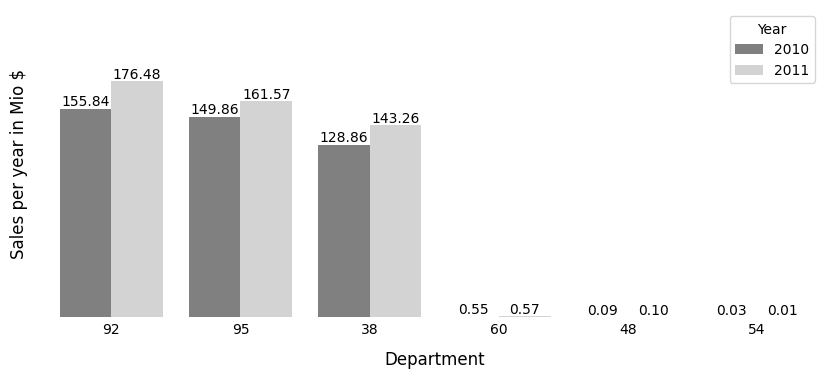

In [99]:
my_pal=['grey', 'lightgrey']

plt.figure(figsize=(10, 4))

ax = sns.barplot(x='Dept', y='Year_Sales', hue='Year', data=df_top_bottom_dept_sorted, palette=my_pal) 
sns.despine(top=True, right=True, left=True, bottom=True)


#def function for format formatting of bar labels
def format_millions(x):
   return f'{x / 1e6:.2f}'

#add labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt=format_millions, label_type='edge')

# y ticks delete
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='y', which='both', length=0)
plt.gca().tick_params(axis='x', which='both', length=0)

plt.title('') #Total sales by store 
plt.xlabel('Department', labelpad=10, fontsize=12)
plt.ylabel('Sales per year in Mio $', labelpad=10, fontsize=12)
plt.legend(title='Year', loc='upper right')
plt.ylim(0, 230000000);

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Store size</div><br>


In [71]:
# giving the bins of Store size labels out of the bin_edges
bin_labels = ["35k-41k", "42k-112k", "113k-126k", "127k-155k", "156k-202k", "202k-203k", "203k-219k"] 

#now create a new column bins with the new created labels and print out the edges (first without labels, then creating labels, then with labels)
df['bins'], bin_edges = pd.qcut(df['Size'], q=7, labels=bin_labels, retbins=True)

In [72]:
df_size_grouped = df.groupby('bins')['Weekly_Sales'].mean()


bins
35k-41k       9728.993017
42k-112k     12279.419445
113k-126k    16995.914105
127k-155k    15161.200703
156k-202k    21617.925317
202k-203k    22332.627682
203k-219k    25200.362504
Name: Weekly_Sales, dtype: float64

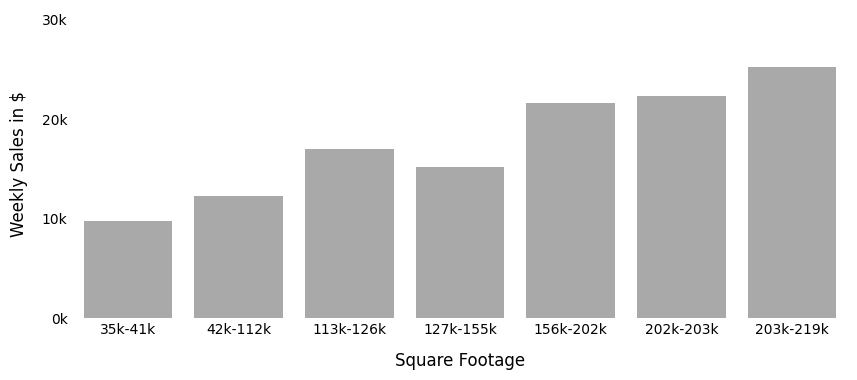

In [114]:
plt.figure(figsize=(10, 4))

ax = sns.barplot(data= df, x='bins', y='Weekly_Sales', color='darkgrey', errorbar=None)

#def function for format formatting of bar labels
def format_millions(x):
    return f'{x / 1e6:.0f}'


sns.despine(top=True, right=True, left=True, bottom=True)

#y ticks as Mio and only some of them
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x / 1000:.0f}k')
ytick_positions = [plt.gca().get_yticks()[0], plt.gca().get_yticks()[2], 
                   plt.gca().get_yticks()[4], plt.gca().get_yticks()[6]]
plt.gca().set_yticks(ytick_positions)
plt.gca().tick_params(axis='y', which='both', length=0)
plt.gca().tick_params(axis='x', which='both', length=0)

plt.ylabel('Weekly Sales in $', labelpad=10, fontsize=12)
plt.xlabel('Square Footage', labelpad=11, fontsize=12)
plt.ylim(0, 31000)
plt.title('', pad=30);

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Reduction in prediction error: baseline model in comparison to best model</div><br>


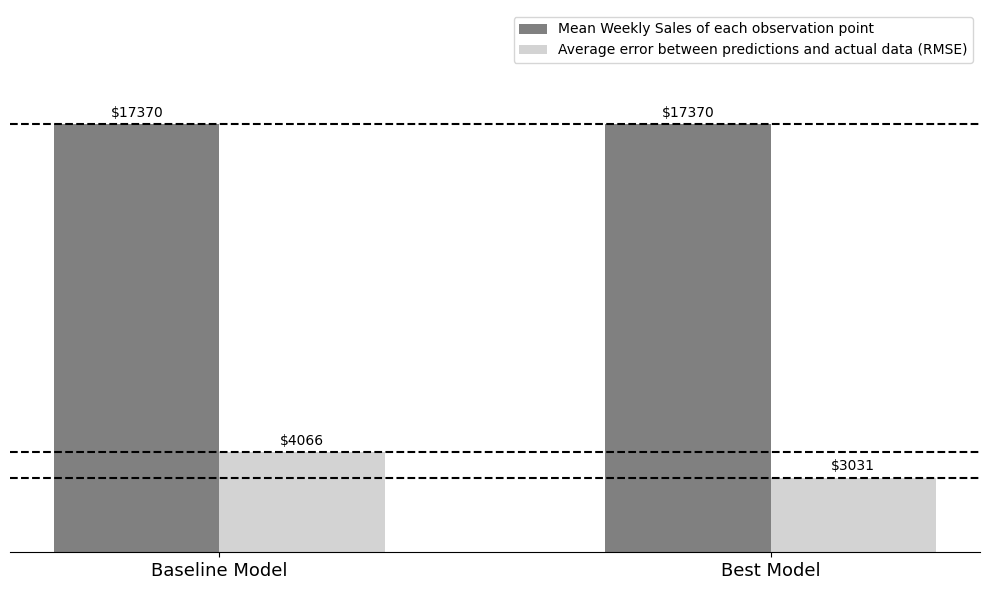

In [108]:
# Data
my_data = {
    "Category": ['Baseline Model', 'Best Model'],
    "Mean weekly sales": [17370, 17370],
    "RMSE": [4066, 3031]
}

my_df = pd.DataFrame(my_data)

# Set the width of each bar
bar_width = 0.3

# Create an array for the x-axis positions
x = np.arange(len(my_df['Category']))

# Create the figure and axes for the subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for "Mean weekly sales" and "RMSE" for Baseline Model
baseline_sales = ax.bar(x - bar_width/2, my_df['Mean weekly sales'], bar_width, label='Mean Weekly Sales of each observation point', color='grey')
baseline_rmse = ax.bar(x + bar_width/2, my_df['RMSE'], bar_width, label='Average error between predictions and actual data (RMSE)', color='lightgray')

# Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(my_df['Category'], size=13)

# Remove the y-axis
ax.get_yaxis().set_visible(False)

# Set y-axis label and title
ax.set_ylabel("Amount ($)")
ax.set_title("")

# Add data labels on top of the bars
for bar in baseline_sales + baseline_rmse:
    height = bar.get_height()
    ax.annotate(f"${height}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


plt.axhline(17370, color='black', linestyle='--')
plt.axhline(3031, color='black', linestyle='--')
plt.axhline(4066, color='black', linestyle='--')

# Display the legend
#ax.legend(location = "top_right")
ax.legend(title="", loc="upper right")
# Adjust the layout
plt.tight_layout()
plt.ylim(0, 22000)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# Show the plot
plt.show()